# Preliminaries

In [ ]:
import torch
from torch.nn import MSELoss

# Intro: Mean Squared Loss 

$\mathrm{MSE}(Y,O)=\dfrac{\sum_{i=1}^n (y_i-o_i)^2}{n}$

In [ ]:
true_values = torch.Tensor([1,2,3,4])
pred_values = torch.Tensor([2,3,4,5])

In [ ]:
loss_calculator = MSELoss() # mean squared loss
loss_calculator(true_values, pred_values)

tensor(1.)

In [ ]:
((true_values-pred_values)**2).sum()/4

tensor(1.)

# Defining a linear model

Our model is like $wx+b$ and we want the result to be similar to the true $y$</br>
The parameters we are going to optimize are $w$ and $b$</br>
**Note that both $b$ and $w$ are gonna have initial values. Our job is to find iteratively how to change them appropriately so that $wx+b$ becomes closer to $y$.**

In [ ]:
w = torch.rand(3, 10, requires_grad=True) # means that we require the gradient with respect to it
x = torch.rand(10, 5)
b = torch.rand(3, 5, requires_grad=True)
model = torch.matmul(w,x) + b
y = torch.rand(3, 5)

In [ ]:
loss_calculator(model, y) # if we have exactly the initial values of "w" and "b", the output of the model will be far away from the true "y"

tensor(7.4932, grad_fn=<MseLossBackward0>)

If there is no tensor we would like the gradient of the loss with respect to it to be computed, then the loss will just be a number.

In [ ]:
x = torch.rand(10, 5)
w = torch.rand(3, 10)
b = torch.rand(3, 5)
model = torch.matmul(w,x) + b
y = torch.rand(3, 5)

In [ ]:
loss_calculator(model, y) # the reason that the loss of the model is different here it just because the values are randomly assigned to "x", "w", "b", and "y"

tensor(4.4279)

In [ ]:
w.requires_grad_(True)
b.requires_grad_(True)
model = torch.matmul(w,x) + b
loss_calculator(model, y)

tensor(4.4279, grad_fn=<MseLossBackward0>)

In [ ]:
loss_calculator(model, y).backward()

$w$ was a $3\times 10$ matrix. The gradient with each of its components will be calculated... (similarly for $b$)

In [ ]:
w.grad

tensor([[0.7090, 0.6445, 0.5329, 0.6608, 0.4321, 1.0568, 0.4229, 1.0133, 0.8406,
         0.6005],
        [0.6023, 0.5862, 0.4930, 0.6475, 0.3952, 1.0138, 0.4100, 0.9004, 0.8660,
         0.5899],
        [0.6032, 0.6643, 0.3673, 0.5875, 0.3214, 0.8693, 0.4410, 0.8159, 0.6095,
         0.3993]])

In [ ]:
w.grad.shape

torch.Size([3, 10])

In [ ]:
b.grad

tensor([[0.3636, 0.3542, 0.2407, 0.2987, 0.2041],
        [0.3491, 0.2877, 0.3062, 0.3256, 0.0954],
        [0.3046, 0.2243, 0.2291, 0.1118, 0.3356]])

In [ ]:
b.grad.shape

torch.Size([3, 5])

## A simpler example

$$\mathrm{model} = w.x$$

In [ ]:
x = torch.Tensor([1])
w = torch.Tensor([1])
w.requires_grad_(True)
y = torch.Tensor([2])
model = torch.matmul(w,x)
loss = loss_calculator(model, y)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [ ]:
loss

tensor(1., grad_fn=<MseLossBackward0>)

## Computational Directed Acyclic Graph (DAG)

Pytorch assigns a DAG to our model. In this directed graph, the leaves are inputs and the roots are the outputs.

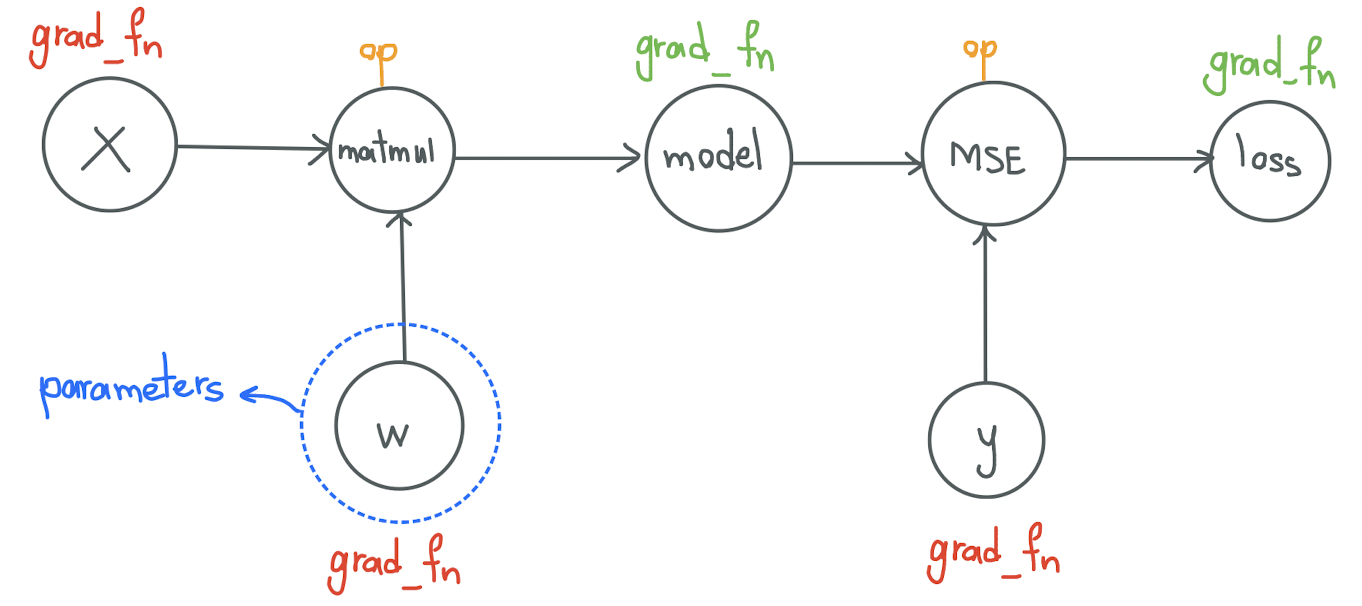

In [ ]:
loss.grad_fn

In [ ]:
model.grad_fn

The `grad_fn` property of a tensor is a reference to the corresponding backward propagation function (computing the gradient of the tensor).

Note that the leaves of the computational graph do not have a `grad_fn` assigned to them.

In [ ]:
x.grad_fn

In [ ]:
w.grad_fn

In [ ]:
y.grad_fn

In [ ]:
loss.backward()

$\mathrm{MSE}(\mathrm{model}, y)=(\mathrm{model}-y)^2$</br>
In this case, the gradient is actually the derivative of our MSE loss with respect to $w$, which is equal to $2(\mathrm{model}-y)=2(wx-y)=2(1.1-2)=2(-1)=-2$

In [ ]:
w.grad # the derivative with respect to w

tensor([-2.])

# Get rid of the `AutoGrad`

Note: There are at least 2 situations where you might not want Pytorch to compute the gradients. The first one is when you just want the forward pass to work (to get the output of the model for a given input), and the second is when you are fine-tuning a pre-trained model and want some of its parameters to be fixed.

In [ ]:
with torch.no_grad():
  model = torch.matmul(w,x)
model.grad_fn

In [ ]:
model.requires_grad

False

Another way...

In [ ]:
model = torch.matmul(w,x)
model.requires_grad_(True)

tensor(1., grad_fn=<DotBackward0>)

In [ ]:
model.grad_fn

In [ ]:
model = model.detach()

In [ ]:
model

tensor(1.)

In [ ]:
model.requires_grad

False

In [ ]:
model.grad_fn

# Vector-Jacobian Product

Assume that your model works like a function $f$ taking a vector $W=(w_1,w_2,\dots,w_d)$ as input and producing an output vector like $O=(o_1,o_2,\dots,o_k)$</br>

If we consider $l(O, \mathrm{TrueOutput})$ as our loss function, according to the chain rule, we have: $$\forall i\in\{1,2,\dots,d\} \quad \frac{\partial l}{\partial w_i}=\sum_{j=1}^{k} \frac{\partial l}{\partial o_j}\frac{\partial o_j}{\partial w_i}$$

Note that $\frac{\partial l}{\partial w_i}$ is an element of the gradient of $l$ with respect to $W$ (which we denote by $G$:

$$G = (\frac{\partial l}{\partial o_1}, \frac{\partial l}{\partial o_2}, \dots, \frac{\partial l}{\partial o_k})^T$$

Also, note that the Jacobian matrix is made like this:

$$J = \begin{pmatrix}
\frac{\partial o_1}{\partial w_1} & \frac{\partial o_2}{\partial w_1} & \dots & \frac{\partial o_k}{\partial w_1} \\
\frac{\partial o_1}{\partial w_2} & \frac{\partial o_2}{\partial w_2} & \dots & \frac{\partial o_k}{\partial w_2} \\
\dots & \dots & \dots & \dots\\
\frac{\partial o_1}{\partial w_d} & \frac{\partial o_2}{\partial w_d} & \dots & \frac{\partial o_k}{\partial w_d}
\end{pmatrix}
$$

The trick reveals itself when you pay attention to the fact that we have:
$$
J.G = \begin{pmatrix}
\frac{\partial o_1}{\partial w_1} & \frac{\partial o_2}{\partial w_1} & \dots & \frac{\partial o_k}{\partial w_1} \\
\frac{\partial o_1}{\partial w_2} & \frac{\partial o_2}{\partial w_2} & \dots & \frac{\partial o_k}{\partial w_2} \\
\dots & \dots & \dots & \dots\\
\frac{\partial o_1}{\partial w_d} & \frac{\partial o_2}{\partial w_d} & \dots & \frac{\partial o_k}{\partial w_d}
\end{pmatrix}_{d\times k} . \begin{pmatrix} \frac{\partial l}{\partial o_1}\\ \frac{\partial l}{\partial o_2}\\ \dots \\ \frac{\partial l}{\partial o_k}\end{pmatrix}_{k\times 1} \\ = \begin{pmatrix}\sum_{j=1}^{k} \frac{\partial l}{\partial o_j}\frac{\partial o_j}{\partial w_1} \\  \sum_{j=1}^{k} \frac{\partial l}{\partial o_j}\frac{\partial o_j}{\partial w_2} \\ \dots \\ \sum_{j=1}^{k} \frac{\partial l}{\partial o_j}\frac{\partial o_j}{\partial w_d}\end{pmatrix} = \begin{pmatrix} \frac{\partial l}{\partial w_1} \\ \frac{\partial l}{\partial w_2} \\ \dots \\ \frac{\partial l}{\partial w_d} \end{pmatrix}
$$